## Funções

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from math import ceil  # Importar a função ceil

pd.options.display.max_columns=50 
pd.options.display.max_rows=80

In [2]:
def find_missing_percent(data):
    """
    Retorna dataframe contendo o total de valores faltantes e porcentagem do total
    de valores faltantes da coluna.
    """
    miss_df = pd.DataFrame({'ColumnName':[],'TotalMissingVals':[],'PercentMissing':[]})
    for col in data.columns:
        sum_miss_val = data[col].isnull().sum()
        percent_miss_val = round((sum_miss_val/data.shape[0])*100,2)
        miss_df.loc[len(miss_df)] = dict(zip(miss_df.columns,[col,sum_miss_val,percent_miss_val]))
    return miss_df

In [3]:
def calculate_outlier_percentage(series, threshold=1.5): # Function to calculate the percentage of outliers for a given series
    z_scores = np.abs((series - series.median()) / series.std())
    outliers = z_scores > threshold
    return (outliers.sum() / len(series)) * 100

In [4]:
def create_multiple_boxplots(data_frame, columns_for_boxplot, titles=None, num_boxplots_per_row=2):
    # Calcular a quantidade;
    num_boxplots = len(columns_for_boxplot)
    num_rows = (num_boxplots + num_boxplots_per_row - 1) // num_boxplots_per_row

    # Criar os subplots
    fig = make_subplots(rows=num_rows, cols=num_boxplots_per_row, subplot_titles=titles)

    # Loop para ir montando todos os gráficos em boxplot
    for idx, column in enumerate(columns_for_boxplot):
        row_idx = idx // num_boxplots_per_row + 1
        col_idx = idx % num_boxplots_per_row + 1

        data = data_frame[column]
        box = go.Box(y=data, name=column)

        fig.add_trace(box, row=row_idx, col=col_idx)

    # Ajustando a forma
    fig.update_layout(height=300*num_rows, showlegend=False)

    # Plotar os gráficos
    fig.show()


In [5]:
def plotar_distribuicoes(data_frame, columns_for_distribution, num_distributions_per_row=2):
    # Calcular a quantidade
    num_distributions = len(columns_for_distribution)
    num_rows = ceil(num_distributions / num_distributions_per_row)

    # Criar os subplots
    fig = make_subplots(rows=num_rows, cols=num_distributions_per_row)

    # Loop para ir montando todos os gráficos de distribuição
    for idx, column in enumerate(columns_for_distribution):
        dados = data_frame[column].dropna()  # Remover valores ausentes

        # Criar o gráfico de histograma
        histogram_data = go.Histogram(x=dados, nbinsx=30, name=f'Histograma - {column}')

        # Adicionar ao subplot
        fig.add_trace(histogram_data,
                      row=(idx // num_distributions_per_row) + 1, col=(idx % num_distributions_per_row) + 1)

    # Atualizar o layout com títulos e legendas adequadas
    for idx, column in enumerate(columns_for_distribution):
        row_idx = (idx // num_distributions_per_row) + 1
        col_idx = (idx % num_distributions_per_row) + 1

        # Adicionar título ao subplot
        fig.update_xaxes(title_text=f'{column}', row=row_idx, col=col_idx)
        fig.update_yaxes(title_text='Quantidade', row=row_idx, col=col_idx)  # Adicionar título ao eixo Y

    # Ajustando a forma
    fig.update_layout(height=300*num_rows, showlegend=False)  # Remover a legenda

    # Plotar os gráficos
    fig.show()

In [6]:
def find_correlated_columns(df, interval):
    """
    Encontra e exibe as correlações entre colunas de um DataFrame.

    Parâmetros:
    - df: DataFrame pandas
    - intervalo de correlação desejado (uma tupla de dois valores)

    Retorna:
    - Lista de tuplas representando pares de colunas correlacionadas.
    """
    correlation_matrix = df.corr(numeric_only=True)
    correlated_columns = []

    # Iterar sobre as combinações de colunas para encontrar correlações
    for i in range(len(correlation_matrix.columns)):
        for j in range(i + 1, len(correlation_matrix.columns)):
            corr = correlation_matrix.iloc[i, j]
            if interval[0] <= abs(corr) <= interval[1]:
                col1 = correlation_matrix.columns[i]
                col2 = correlation_matrix.columns[j]
                correlated_columns.append((col1, col2))
                print(f"Correlação entre {col1} e {col2}: {corr}")

    # Plotar um mapa de calor da matriz de correlação
    plt.figure(figsize=(20, 16))
    sns.heatmap(correlation_matrix, annot=True, cmap='cubehelix_r')
    plt.title('Matriz de Correlação')
    plt.xlabel('Variáveis')
    plt.ylabel('Variáveis')
    plt.show()

    return correlated_columns

In [7]:
def correlacao_com_variavel_alvo(df, target_variable, nivel="forte", top_n=5):
    """
    Imprime as n features com as maiores correlações com uma variável alvo, com base no nível escolhido.

    Parâmetros:
    - df: DataFrame pandas.
    - target_variable: String, nome da variável alvo.
    - nivel: String que define o critério de correlação ("forte", "fraca", etc.).
    - top_n: Número inteiro, quantidade de features a serem impressas.

    Retorna:
    - Nenhum (imprime as correlações).
    """
    correlation_matrix = df.corr(numeric_only=True)

    # Filtra as correlações com base no nível escolhido
    if nivel.lower() == "forte":
        filtered_correlations = correlation_matrix[((correlation_matrix >= 0.7) & (correlation_matrix < 1.0)) | ((correlation_matrix <= -0.7) & (correlation_matrix > -1.0))]
    else:
        raise ValueError("Nível não suportado. Atualmente, apenas 'forte' é suportado.")

    # Filtra as correlações com a variável alvo
    correlations_with_target = filtered_correlations[target_variable].sort_values(ascending=False)

    # Pegar as n maiores correlações
    top_n_correlations = correlations_with_target.head(top_n)

    # Imprimir as n maiores correlações com a variável alvo
    print(f"As {top_n} maiores correlações com '{target_variable}' ({nivel}):")
    for feature, correlation in top_n_correlations.items():
        print(f"{feature}: {correlation}")

## Análise da Base

Faremos a junção de todas as tabelas em uma só para facilitar a manipulação conjunta dos dados

In [8]:
# Carregando as bases
channels = pd.read_csv('channels.csv')
deliveries = pd.read_csv('deliveries.csv')
drivers = pd.read_csv('drivers.csv')
hubs = pd.read_csv('hubs.csv')
orders = pd.read_csv('orders.csv')
payments = pd.read_csv('payments.csv')
stores = pd.read_csv('stores.csv')

# Fazendo a unificação
deliveries = pd.merge(left=drivers, right=deliveries, on='driver_id', how ='right')
stores = pd.merge(left=hubs, right=stores, on='hub_id', how ='right')
df = pd.merge(left=channels, right=orders, on='channel_id', how ='right')
df = pd.merge(left=payments, right=df, on='payment_order_id', how ='right')
df = pd.merge(left=deliveries, right=df, on='delivery_order_id', how ='right')
df = pd.merge(left=stores, right=df, on='store_id', how ='right')


In [9]:
df.duplicated().sum()

0

In [10]:
# Criando uma coluna de data com base nas colunas existentes
df.rename(columns = {'order_created_year':'year','order_created_month':'month','order_created_day':'day', 'order_created_hour': 'hour', 'order_created_minute': 'minute'}, inplace=True)
df['order_date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute']])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442239 entries, 0 to 442238
Data columns (total 54 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   hub_id                             442239 non-null  int64         
 1   hub_name                           442239 non-null  object        
 2   hub_city                           442239 non-null  object        
 3   hub_state                          442239 non-null  object        
 4   hub_latitude                       442239 non-null  float64       
 5   hub_longitude                      442239 non-null  float64       
 6   store_id                           442239 non-null  int64         
 7   store_name                         442239 non-null  object        
 8   store_segment                      442239 non-null  object        
 9   store_plan_price                   347795 non-null  float64       
 10  store_latitude      

In [33]:
miss_df = find_missing_percent(df)
'''Displays columns with missing values'''
display(miss_df[miss_df['PercentMissing']>0.0])
print("\n")
print(f"Número de colunas com valores faltantes:{str(miss_df[miss_df['PercentMissing']>0.0].shape[0])}")

,ColumnName,TotalMissingVals,PercentMissing




Número de colunas com valores faltantes:0


In [12]:
# Tirando as colunas com mais de 20% de dados faltantes
for coluna in miss_df.loc[miss_df['PercentMissing'] > 20]['ColumnName']:
    df.drop(columns=coluna, inplace=True)

Com base na análise da funcionalidade de cada coluna e na porcentagem de dados faltantes, vamos focar somente nas que podem nos trazer mais resultados e excluir as mais problemáticas

In [13]:
#df_merged = df.copy()

colunas_interesse = ['hub_name', 'hub_city', 'hub_state',
       'store_name', 'store_segment',
       'driver_modal',
       'driver_type', 'delivery_distance_meters', 'delivery_status',
       'payment_amount', 'payment_fee', 'payment_method',
       'payment_status', 'channel_name', 'channel_type',
       'order_status', 'order_amount', 'order_delivery_fee',
       'order_delivery_cost',
       'order_metric_collected_time', 'order_metric_paused_time',
       'order_metric_production_time', 'order_metric_walking_time',
       'order_metric_expediton_speed_time', 'order_metric_transit_time',
       'order_metric_cycle_time', 'order_date']

'''
mais interessantes: 
criar coluna de tempo!! ou data
store_segment
driver_modal
delivery_distance_meters
delivery_status e order_status iguais?
payment_amount e order_amount iguais?
'''

df = df[colunas_interesse]

'''Separando dados numéricos e categóricos '''
numeric_cols = df.select_dtypes(['float','int']).columns
categoric_cols = df.select_dtypes('object').columns

df_numeric = df[numeric_cols]
df_categoric = df[categoric_cols]

In [14]:
numeric_cols = df.select_dtypes(['float','int']).columns
for feature in numeric_cols:
    qtd_outliers = calculate_outlier_percentage(df[feature]).round(2)
    print(f'{qtd_outliers} % | {feature}' )

#Fazer boxplots, para visualizar os outliers
colunas = ['delivery_distance_meters', 'payment_amount', 'payment_fee',
       'order_amount', 'order_delivery_fee', 'order_delivery_cost',
       'order_metric_collected_time', 'order_metric_paused_time',
       'order_metric_production_time', 'order_metric_walking_time',
       'order_metric_expediton_speed_time', 'order_metric_transit_time',
       'order_metric_cycle_time']
#create_multiple_boxplots(df, colunas,num_boxplots_per_row=5)

0.11 % | delivery_distance_meters
1.32 % | payment_amount
1.86 % | payment_fee
0.02 % | order_amount
1.2 % | order_delivery_fee
8.25 % | order_delivery_cost
0.43 % | order_metric_collected_time
0.71 % | order_metric_paused_time
0.88 % | order_metric_production_time
0.45 % | order_metric_walking_time
1.9 % | order_metric_expediton_speed_time
0.26 % | order_metric_transit_time
1.07 % | order_metric_cycle_time


In [15]:
# Plotar distribuições
#plotar_distribuicoes(df, colunas)

In [16]:
linhas_antes = df.shape[0]

# removendo outliers de delivery_distance_meters
outliers = df[df['delivery_distance_meters'] > 7000].index
df.drop(outliers, inplace=True)

# removendo outliers de payment_amount
outliers = df[df['payment_amount'] > 280].index
df.drop(outliers, inplace=True)

# removendo outliers de payment_fee
outliers = df[df['payment_fee'] > 10].index
df.drop(outliers, inplace=True)

# removendo outliers de order_amount
outliers = df[df['order_amount'] > 280].index
df.drop(outliers, inplace=True)

# removendo outliers de order_delivery_fee
outliers = df[df['order_delivery_fee'] > 27].index
df.drop(outliers, inplace=True)

# removendo outliers de order_delivery_cost
outliers = df[df['order_delivery_cost'] > 15].index
df.drop(outliers, inplace=True)

# removendo outliers de order_metric_collected_time
outliers = df[(df['order_metric_collected_time'] > 7) | (df['order_metric_walking_time'] < 0)].index
df.drop(outliers, inplace=True)

# removendo outliers de order_metric_paused_time
outliers = df[ (df['order_metric_paused_time'] < 0) | (df['order_metric_paused_time'] > 20)].index
df.drop(outliers, inplace=True)

# removendo outliers de order_metric_production_time
outliers = df[df['order_metric_production_time'] > 45].index
df.drop(outliers, inplace=True)

# removendo outliers de order_metric_walking_time
outliers = df[(df['order_metric_walking_time'] > 10) | (df['order_metric_walking_time'] < 0)].index
df.drop(outliers, inplace=True)

# removendo outliers de order_metric_expediton_speed_time
outliers = df[df['order_metric_expediton_speed_time'] > 20].index
df.drop(outliers, inplace=True)

# removendo outliers de order_metric_transit_time
outliers = df[df['order_metric_transit_time'] > 45].index
df.drop(outliers, inplace=True)

# removendo outliers de order_metric_cycle_time
outliers = df[df['order_metric_cycle_time'] > 80].index
df.drop(outliers, inplace=True)

df.reset_index(drop=True, inplace=True)

linhas_depois = df.shape[0]
restante = round((100* linhas_depois / linhas_antes), 2)
print(f'total de linhas retiradas: {linhas_antes - linhas_depois} (restam {linhas_depois} linhas que equivalem a {restante}% da base inicial)')

total de linhas retiradas: 98260 (restam 343979 linhas que equivalem a 77.78% da base inicial)


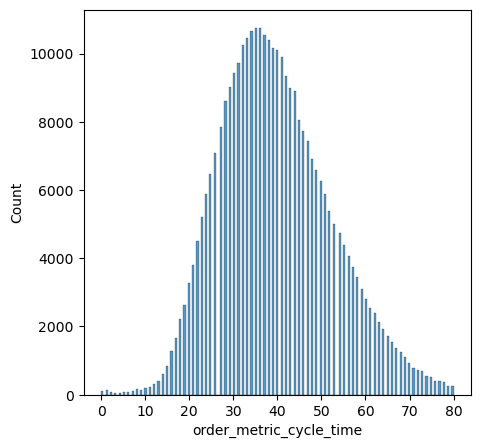

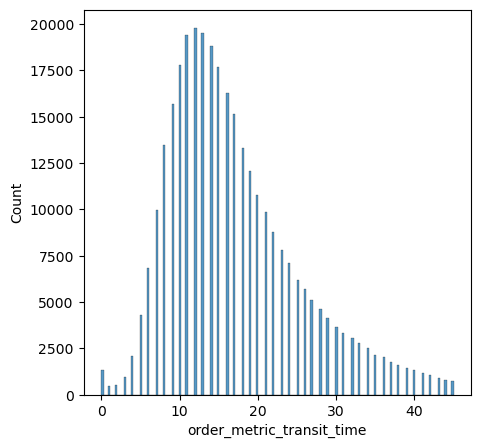

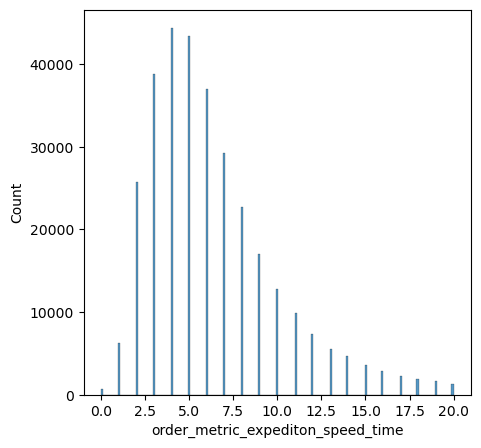

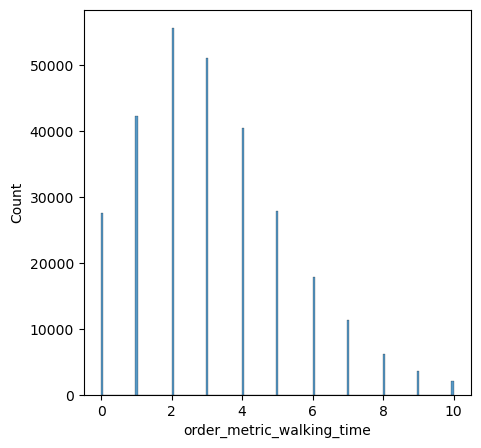

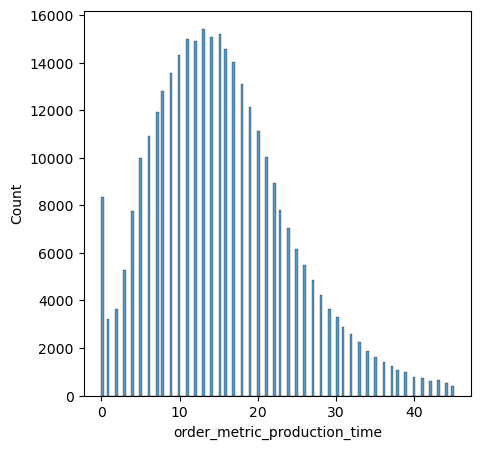

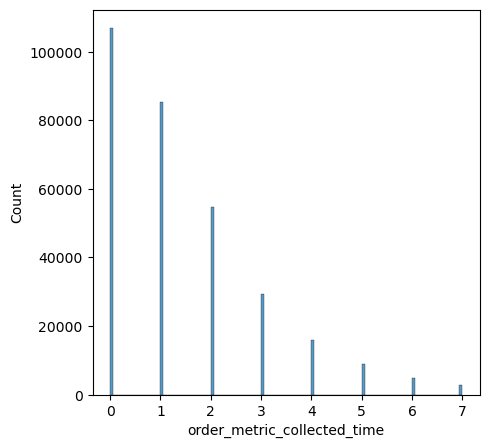

In [17]:
colunas_verificar = ['order_metric_cycle_time','order_metric_transit_time', 'order_metric_expediton_speed_time', 
                     'order_metric_walking_time', 'order_metric_production_time', 'order_metric_collected_time']
for coluna in colunas_verificar:
    plt.figure(figsize=(5,5))
    sns.histplot(df, x=coluna)
    plt.show()

In [18]:
#df[df['order_metric_cycle_time'].eq(0)]

In [19]:
round(df[colunas].describe().T,2)

,count,mean,std,min,25%,50%,75%,max
delivery_distance_meters,334350.0,2171.79,1437.93,0.0,1070.00,1850.0,2970.00,7000.00
payment_amount,329221.0,75.59,58.61,0.0,30.11,59.9,109.60,280.00
payment_fee,329063.0,1.54,1.61,0.0,0.40,0.9,2.37,9.97
order_amount,343979.0,77.31,52.62,0.0,36.00,61.0,104.00,280.00
order_delivery_fee,343979.0,5.43,4.70,0.0,0.00,6.0,11.00,27.00
order_delivery_cost,338310.0,6.68,2.48,0.0,5.00,7.0,8.00,15.00
order_metric_collected_time,308969.0,1.42,1.54,0.0,0.00,1.0,2.00,7.00
order_metric_paused_time,289987.0,2.89,3.32,0.0,1.00,2.0,4.00,20.00
order_metric_production_time,323286.0,15.37,8.73,0.0,9.00,14.0,21.00,45.00
order_metric_walking_time,285869.0,3.13,2.17,0.0,2.00,3.0,4.00,10.00


Com base nos cálculos de outliers e visualização dos dados vamos tratar as features:

In [20]:
#sns.histplot(df, x='order_metric_cycle_time')

In [21]:
#sns.barplot(data=df, x='order_status', y='order_metric_production_time')

In [22]:
#sns.barplot(data=df, x='driver_modal', y='order_metric_transit_time')

In [23]:
#df_numeric.head(2)

In [24]:
df_categoric.head(2)

,hub_name,hub_city,hub_state,store_name,store_segment,driver_modal,driver_type,delivery_status,payment_method,payment_status,channel_name,channel_type,order_status
0,HIP HOP SHOPPING,RIO DE JANEIRO,RJ,IUMPICA,FOOD,MOTOBOY,FREELANCE,DELIVERED,ONLINE,PAID,FOOD PLACE,MARKETPLACE,FINISHED
1,PAGODE SHOPPING,S�O PAULO,SP,MUMRIFAM,GOOD,MOTOBOY,FREELANCE,DELIVERED,ONLINE,PAID,LONDON PLACE,MARKETPLACE,FINISHED


In [25]:
round(df[colunas].describe().T,2)

,count,mean,std,min,25%,50%,75%,max
delivery_distance_meters,334350.0,2171.79,1437.93,0.0,1070.00,1850.0,2970.00,7000.00
payment_amount,329221.0,75.59,58.61,0.0,30.11,59.9,109.60,280.00
payment_fee,329063.0,1.54,1.61,0.0,0.40,0.9,2.37,9.97
order_amount,343979.0,77.31,52.62,0.0,36.00,61.0,104.00,280.00
order_delivery_fee,343979.0,5.43,4.70,0.0,0.00,6.0,11.00,27.00
order_delivery_cost,338310.0,6.68,2.48,0.0,5.00,7.0,8.00,15.00
order_metric_collected_time,308969.0,1.42,1.54,0.0,0.00,1.0,2.00,7.00
order_metric_paused_time,289987.0,2.89,3.32,0.0,1.00,2.0,4.00,20.00
order_metric_production_time,323286.0,15.37,8.73,0.0,9.00,14.0,21.00,45.00
order_metric_walking_time,285869.0,3.13,2.17,0.0,2.00,3.0,4.00,10.00


# Preenchendo vazios #

Quando se tem muito outlier, a mediana eh utilizada, como removemos os outliers nos codigos acima, nao utilizaremos a mediana.
Todos os dados que vamos substituir seguem uma distribuicao discreta, o que convem substituir pela moda. Mas para os dados com distribuicao normal, eh possivel de se substituir pela media, dado que os outliers nao interfiram

In [32]:

# Preencher NaN em 'delivery_status' com 'DELIVERED' onde 'order_metric_cycle_time' não é NaN, pois sempre que tem o tempo do ciclo total, eh pq ele foi entregue
df.loc[df['order_metric_cycle_time'].notnull() & df['delivery_status'].isnull(), 'delivery_status'] = 'DELIVERED'


# Calcular o segundo valor mais frequente em 'delivery_status', ja que o mais frequente eh DELIVERED
second_most_frequent_value = df['delivery_status'].value_counts().index[1]

# Preencher NaN em 'delivery_status' com o segundo valor mais frequente, pois sabemos que nao foi entregue, agora ele pode estar sendo entregue ou pode ter sido cancelado
df['delivery_status'].fillna(second_most_frequent_value, inplace=True)

# Essas duas colunas sempre devem estar preenchidas, independentemente do status de entrega
df['delivery_distance_meters'].fillna(df['delivery_distance_meters'].mean(), inplace=True)
df['order_delivery_cost'].fillna(df['order_delivery_cost'].mean(), inplace=True)


#A seguir colunas que so possuem valor se o pedido nao foi cancelado
# Condição para preencher apenas quando delivery_status nao for 'CANCELED'
condition1 = df['delivery_status'] != 'CANCELED'

# Lista das colunas a serem preenchidas com a moda
columns_to_fill_mode = [
    'driver_modal',
    'driver_type',
    'payment_method',
    'payment_status',
    'payment_amount',
    'payment_fee'
]

# Preencher os valores faltantes com a mediana nas colunas específicas quando delivery_status for 'DELIVERED'
for column in columns_to_fill_mode:
    mode_value = df.loc[condition1, column].mode().iloc[0]
    df.loc[condition1 & df[column].isnull(), column] = mode_value


#A seguir colunas que so possuem valor se o pedido foi entregue
# Condição para preencher apenas quando delivery_status for 'DELIVERED'
condition2 = df['delivery_status'] == 'DELIVERED'

# Lista das colunas a serem preenchidas com a media, pois seguem uma distribuicao normal
columns_to_fill_mean = [
    'order_metric_production_time', 
    'order_metric_expediton_speed_time', 
    'order_metric_transit_time', 
    'order_metric_walking_time'
]

# Preencher os valores faltantes com a mediana nas colunas específicas quando delivery_status for 'DELIVERED'
for column in columns_to_fill_mean:
    mean_value = df.loc[condition2, column].mean()
    df.loc[condition2 & df[column].isnull(), column] = mean_value

    
# Lista das colunas a serem preenchidas com a moda, pois nao seguem uma distribuicao normal
columns_to_fill_mode = [
    'order_metric_collected_time', 
    'order_metric_paused_time'
]

# Preencher os valores faltantes com a media nas colunas específicas quando delivery_status for 'DELIVERED'
for column in columns_to_fill_mode:
    mode_value = df.loc[condition2, column].mean()
    df.loc[condition2 & df[column].isnull(), column] = mode_value



# Criar a soma das colunas desejadas
sum_columns = df[
    ['order_metric_production_time', 
    'order_metric_expediton_speed_time', 
    'order_metric_transit_time', 
    'order_metric_collected_time', 
    'order_metric_paused_time', 
    'order_metric_walking_time']
].sum(axis=1)

# Preencher os valores faltantes em 'order_metric_cycle_time' com a soma das colunas
df['order_metric_cycle_time'].fillna(sum_columns, inplace=True)


# Descartar linhas onde a condição não é satisfeita
df = df[condition2]


In [34]:
df.to_csv('Dados_Com')